In [1]:
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import doc_utils
import defines

## Give a try to AlephBERT

In [2]:
from transformers import BertModel, BertTokenizerFast


In [3]:
alephbert_tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
alephbert = BertModel.from_pretrained('onlplab/alephbert-base', return_dict=False)

# if not finetuning - disable dropout
alephbert.eval()

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(52000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [4]:
from transformers import pipeline
fill_mask = pipeline(
    'feature-extraction',
    model=alephbert,
    tokenizer=alephbert_tokenizer
)

In [5]:
random_str  = "אנחנו עכשיו בחברה בגלל שיש את כל הצמצומים אז חלק מהחברה החברה הרי עברו עם משרדים וחלק השכירו לחברה אחרת והתכנון היה שבעתיד אנחנו נגדל ככה שנגיד לחברה הזאת ביי ביי ונכנס"

In [6]:
tokens = alephbert_tokenizer.tokenize(random_str)

In [7]:
# encode text
text = random_str
sent_id = alephbert_tokenizer.batch_encode_plus([text], padding=True)

# output
print(sent_id)

{'input_ids': [[2, 2340, 2275, 5345, 2674, 2265, 1810, 1871, 1960, 18314, 1944, 2039, 2405, 18176, 2820, 2522, 6309, 1880, 12185, 7692, 27696, 1835, 6024, 3016, 2858, 4410, 1966, 45105, 2340, 2225, 1009, 2692, 13340, 1847, 6024, 2900, 3543, 3543, 19351, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [8]:
def concat_sent_dbs():
    sent_db = pd.concat([pd.read_csv(i,usecols=['text','is_nar','nar_idx','sent_len','is_client']) for i in glob.glob(os.path.join(os.path.join(os.getcwd(),defines.PATH_TO_DFS,"*_sent_db.csv")))])
    sent_db.reset_index(inplace=True,drop=True)
    return sent_db

In [9]:
i=10
# sent_db = pd.read_csv(os.path.join(os.getcwd(),defines.PATH_TO_DFS,"{:02d}_sent_db.csv".format(i)),usecols=['text','is_nar'])
sent_db = concat_sent_dbs()
df = sent_db

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
# device = torch.device("cuda")
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['is_nar'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['is_nar'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

<AxesSubplot:>

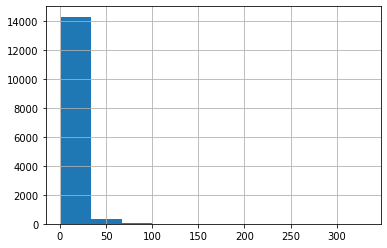

In [11]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist()

In [27]:
tokens_train = alephbert_tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = alephbert_tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = alephbert_tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
)

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
tokens_train

{'input_ids': [[2, 1837, 3590, 1880, 1845, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2618, 1813, 3140, 3032, 11442, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1969, 2879, 31273, 2039, 3088, 2445, 11442, 24949, 2641, 6530, 2096, 1985, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 13137, 3322, 1884, 2636, 1813, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2812, 2978, 1810, 1845, 1845, 30275, 2269, 2167, 1845, 5275, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2870, 2390, 1806, 21806, 1838, 2072, 2150, 2455, 1966, 2445, 12932, 2072, 1985, 3475, 2142, 39860, 18235, 1838, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2324, 1985, 2221, 39541, 23940, 2188, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1813, 1845, 8481, 1876, 2441, 1990, 1064, 3090, 6726, 3587, 6903, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 4466, 12737, 5128, 2

In [29]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
# train_y = torch.tensor(train_labels.tolist())
train_y = torch.tensor(train_labels.tolist(),dtype=torch.long )

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
# val_y = torch.tensor(val_labels.tolist())
val_y = torch.tensor(val_labels.tolist(),dtype=torch.long )

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist())
test_y = torch.tensor(test_labels.tolist(),dtype=torch.long )

<ipython-input-29-99c6f78bc201>:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_y = torch.tensor(train_labels.tolist(),dtype=torch.long )
<ipython-input-29-99c6f78bc201>:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  val_y = torch.tensor(val_labels.tolist(),dtype=torch.long )
<ipython-input-29-99c6f78bc201>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  test_y = torch.tensor(test_labels.tolist(),dtype=torch.long )


In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [31]:
train_data[0]

(tensor([   2, 1837, 3590, 1880, 1845,    3,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 tensor(0))

In [32]:
# freeze all the parameters
for param in alephbert.parameters():
    param.requires_grad = False

In [33]:
class BERT_Arch(nn.Module):

  def __init__(self, bert):
    
    super(BERT_Arch, self).__init__()

    self.bert = bert 

    # dropout layer
    self.dropout = nn.Dropout(0.1)

    # relu activation function
    self.relu =  nn.ReLU()

    # dense layer 1
    self.fc1 = nn.Linear(768,512)

    # dense layer 2 (Output layer)
    self.fc2 = nn.Linear(512,2)

    #softmax activation function
    self.softmax = nn.LogSoftmax(dim=1)

  #define the forward pass
  def forward(self, sent_id, mask):

    #pass the inputs to the model  
    #       _, cls_hs = self.bert(sent_id, attention_mask=mask)
    _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)

    x = self.fc1(cls_hs)

    x = self.relu(x)

    x = self.dropout(x)

    # output layer
    x = self.fc2(x)

    # apply softmax activation
    x = self.softmax(x)

    return x

In [34]:

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(alephbert)
# push the model to GPU
# model = model.to(device)

In [35]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rat

In [36]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.77312822 1.41532103]


In [37]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
# weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [38]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(train_dataloader)))

        # push the batch to gpu
        #     batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds

In [44]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
#         if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
#             elapsed = format_time(time.time() - t0)

            # Report progress.
        #       print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        #     batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [45]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    461.
  Batch   100  of    461.
  Batch   150  of    461.
  Batch   200  of    461.
  Batch   250  of    461.
  Batch   300  of    461.
  Batch   350  of    461.
  Batch   400  of    461.
  Batch   450  of    461.

Evaluating...

Training Loss: 0.634
Validation Loss: 0.624

 Epoch 2 / 10
  Batch    50  of    461.
  Batch   100  of    461.
  Batch   150  of    461.
  Batch   200  of    461.
  Batch   250  of    461.
  Batch   300  of    461.
  Batch   350  of    461.
  Batch   400  of    461.
  Batch   450  of    461.

Evaluating...

Training Loss: 0.622
Validation Loss: 0.617

 Epoch 3 / 10
  Batch    50  of    461.
  Batch   100  of    461.
  Batch   150  of    461.
  Batch   200  of    461.
  Batch   250  of    461.
  Batch   300  of    461.
  Batch   350  of    461.
  Batch   400  of    461.
  Batch   450  of    461.

Evaluating...

Training Loss: 0.616
Validation Loss: 0.612

 Epoch 4 / 10
  Batch    50  of    461.
  Batch   100  of    461.
  Batc

### Load Saved Model

In [24]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Get Predictions for Test Data

In [25]:
# get predictions for test data
with torch.no_grad():
      preds = model(test_seq, test_mask)
      preds = preds.detach().cpu().numpy()

In [26]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.83      0.71      0.76        48
           1       0.39      0.56      0.46        16

    accuracy                           0.67        64
   macro avg       0.61      0.64      0.61        64
weighted avg       0.72      0.67      0.69        64



In [ ]:
codes = alephbert_tokenizer.encode(random_str)

In [ ]:
tokenized = sent_db['text'].apply((lambda x: alephbert_tokenizer.encode(x, add_special_tokens=True,padding='max_length', truncation=False)))

In [ ]:
tokenized

In [ ]:
inputs = alephbert_tokenizer(sent_db.loc[0,'text'], return_tensors="pt")
output = alephbert(**inputs)

In [ ]:
output